<a href="https://colab.research.google.com/github/comojin1994/Machine_Learning/blob/master/Regression/KBO_Batter_OPS_Estimate_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd ./drive/My\ Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [3]:
!ls

 회귀해석_교수님과제2.ipynb		    pre_models
 회귀해석_6주차_A.ipynb			    review_data
'Chapter 05 - 실전 웹 크롤링_After.ipynb'   sentiment
 Colab_MeCab_tutorial.ipynb		    Sentiment_BOW.ipynb
'Colab Notebooks.zip'			    Sentiment_CNN.ipynb
 crop.data.csv				    Sentiment_CNN_PretrainTest.ipynb
 Data					    Sentiment_RNN.ipynb
 EDA.ipynb				    Sentiment_RNN_PretrainTest.ipynb
'Job proficiency data.csv'		    sentiment_vader.ipynb
 KBO_Batter_OPS_Estimate_MLP.ipynb	    sonny_cnn
 mathematical_statistics2_project.ipynb     wiki
 model					    Word2Vec_Wiki.ipynb
 nng.csv				    Word2Vec_Wiki_Pretrain.ipynb
 nsm					    word_count_sample_en.ipynb
 pizza_bot				    word_count_sample_ko.ipynb


In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics

import os, time, itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### 경로확인 

In [5]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks'

#### 데이터 준비 

In [6]:
batter = pd.read_csv('./Data/Regular_Season_Batter.csv')

batter['Age'] = batter['year'] - batter['year_born'].apply(lambda x: int(x[:4]))

batter['height/weight'] = batter['height/weight'].fillna('0cm/0kg')

batter['height'] = batter['height/weight'].apply(lambda x: int(x.split('/')[0][:-2]))
batter['weight'] = batter['height/weight'].apply(lambda x: int(x.split('/')[1][:-2]))

mean_h = np.mean(batter['height'][batter['height'] != 0])
mean_w = np.mean(batter['weight'][batter['weight'] != 0])

batter['height'] = batter['height'].apply(lambda x: mean_h if x == 0 else x)
batter['weight'] = batter['weight'].apply(lambda x: mean_w if x == 0 else x)

batter = batter[batter['AB'] >= 396]

batter = batter.drop(1935, axis = 0)

batter_conti = batter.drop(['batter_id', 'year', 'year_born', 'batter_name',
                            'team', 'position', 'career', 'starting_salary', 'height/weight'], axis=1)

#### Target 분리 

In [7]:
target_OPS = batter_conti['OPS']

batter_conti_ = batter_conti.drop(['avg', 'OPS', 'SLG', 'OBP'], axis=1)
batter_conti_1 = sm.add_constant(batter_conti_, has_constant='add')

#### 학습데이터 / 평가데이터 분할

In [8]:
feature_columns = list(batter_conti_1.columns)

X = batter_conti_1[feature_columns]
y = target_OPS
train_x, test_x, train_y, test_y = train_test_split(X, y, train_size=0.7, test_size=0.3)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((332, 20), (143, 20), (332,), (143,))

### Baseline (Full) 모델 적합 

In [9]:
full_model = sm.OLS(train_y, train_x)
fitted_full_model = full_model.fit()
print(fitted_full_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    OPS   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2132.
Date:                Sun, 21 Jun 2020   Prob (F-statistic):          4.28e-315
Time:                        08:18:32   Log-Likelihood:                 1066.3
No. Observations:                 332   AIC:                            -2095.
Df Residuals:                     313   BIC:                            -2022.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8011      0.031     25.508      0.0

### 단계적 선택법을 통한 모델 적합

In [10]:
def processSubset(X, y, feature_set):
    model = sm.OLS(y, X[list(feature_set)])
    regr = model.fit()
    AIC = regr.aic
    return {'model': regr, 'AIC': AIC}

def getBest(X, y, k):
    tic = time.time() # 시작시간
    results = [] # 결과 저장공간
    for combo in itertools.combinations(X.columns.difference(['const']), k): # 각 변수조합을 고려한 경우의 수
        combo = (list(combo) + ['const'])
        
        results.append(processSubset(X, y, feature_set=combo)) # 모델링된 것들을 저장
    models = pd.DataFrame(results)
    # 가장 낮은 AIC를 가지는 모델 선택 및 저장
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print('Processed', models.shape[0], 'models on', k, 'predictors in', (toc - tic), 'seconds')
    return best_model

def forward(X, y, predictors):
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(X=X, y= y, feature_set=predictors+[p]+['const']))
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)

    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()] # index
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model

def backward(X,y,predictors):
    tic = time.time()
    results = []
    # 데이터 변수들이 미리정의된 predictors 조합 확인
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X, y= y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors) - 1, "predictors in",
          (toc - tic))
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model

def Stepwise_model(X, y):
    Stepmodels = pd.DataFrame(columns=['AIC', 'model'])
    tic = time.time()
    predictors = []
    Smodel_before = processSubset(X, y, predictors+['const'])['AIC']
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns.difference(['const']))+1):
        Forward_result = forward(X=X, y=y, predictors=predictors)
        print('forward')
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]['model'].model.exog_names
        predictors = [k for k in predictors if k != 'const']
        Backward_result = backward(X=X, y=y, predictors=predictors)
        if Backward_result['AIC'] < Forward_result['AIC']:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]['model'].model.exog_names
            Smodel_before = Stepmodels.loc[i]['AIC']
            predictors = [k for k in predictors if k != 'const']
            print('backward')
        if Stepmodels.loc[i]['AIC'] > Smodel_before: break
        else: Smodel_before = Stepmodels.loc[i]['AIC']
        
    toc = time.time()
    print('Total elapsed time:', (toc - tic), 'seconds')
    
    return (Stepmodels['model'][len(Stepmodels['model'])])

In [11]:
Stepwise_best_model = Stepwise_model(X=X, y=y)

Processed  19 models on 1 predictors in 0.04106020927429199
Selected predictors: ['TB', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f079bf75518>
forward
Processed  1 models on 0 predictors in 0.0038576126098632812
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f079bfd6908>
Processed  18 models on 2 predictors in 0.03600621223449707
Selected predictors: ['TB', 'AB', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f079bfd6b00>
forward
Processed  2 models on 1 predictors in 0.00787043571472168
Selected predictors: ['TB', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f079d3372b0>
Processed  17 models on 3 predictors in 0.037278175354003906
Selected predictors: ['TB', 'AB', 'H', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f079bfd6ef0>
forward
Processed

In [12]:
print(Stepwise_best_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    OPS   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     5893.
Date:                Sun, 21 Jun 2020   Prob (F-statistic):               0.00
Time:                        08:18:33   Log-Likelihood:                 1545.2
No. Observations:                 475   AIC:                            -3068.
Df Residuals:                     464   BIC:                            -3023.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
TB             0.0022   2.83e-05     77.551      0.0

In [13]:
mse_full = metrics.mean_squared_error(test_y, fitted_full_model.predict(test_x))
mse_step = metrics.mean_squared_error(test_y, Stepwise_best_model.predict(test_x[Stepwise_best_model.model.exog_names]))
print(f'mse_full: {mse_full}')
print(f'mse_Stepwise: {mse_step}')

mse_full: 7.013323411716015e-05
mse_Stepwise: 6.12070102894782e-05


# MLP 모델 적합

In [62]:
import tensorflow as tf
from tensorflow.keras.layers import *

## Hyperparameter 

In [63]:
num_epochs = 1000
batch_size = 2

## Model 

In [64]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense1 = Dense(1024, activation='relu')
        self.bn1 = BatchNormalization()
        self.dense2 = Dense(1024, activation='relu')
        self.bn2 = BatchNormalization()
        self.dense3 = Dense(19, activation='relu')
        self.dense4 = Dense(1)
        
    def call(self, x, training=False):
        x = self.dense1(x)
        x = self.bn1(x, training=training)
        x = tf.keras.layers.Dropout(.5)(x, training=training)
        x = self.dense2(x)
        x = self.bn2(x, training=training)
        x = tf.keras.layers.Dropout(.5)(x, training=training)
        x = self.dense3(x)
        x = self.dense4(x)
        return x

In [65]:
train_x.shape, train_y.shape

((332, 20), (332,))

In [66]:
train_ds = tf.data.Dataset.from_tensor_slices((np.array(train_x), np.array(train_y))).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((np.array(test_x), np.array(test_y))).batch(batch_size)

In [75]:
@tf.function
def train_step(model, datas, labels, loss_object, optimizer, train_loss, train_accuracy):
    with tf.GradientTape() as tape:
        predictions = model(datas, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)
    
@tf.function
def test_step(model, datas, labels, loss_object, test_loss, test_accuracy):
    predictions = model(datas, training=False)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

## Define model, loss ftn, optimizer, metric 

In [76]:
model = MLP()

loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.MeanSquaredError(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.MeanSquaredError(name='test_accuracy')

## Training 

In [77]:
best_loss = 10**6
early_stop = 0
loss_train = []
loss_test = []

for epoch in range(num_epochs):
    for datas, labels in train_ds:
        train_step(model, datas, labels, loss_object, optimizer, train_loss, train_accuracy)
        
    for datas, labels in test_ds:
        test_step(model, datas, labels, loss_object, test_loss, test_accuracy)
    
    if best_loss > test_loss.result():
      best_loss = test_loss.result()
    else:
      early_stop += 1
      if early_stop == 10:
        template = 'Epoch {}, Loss: {}, Accuracy {}, Test Loss: {}, Test Accuracy: {}'
        print(template.format(
            epoch + 1,
            train_loss.result(),
            train_accuracy.result(),
            test_loss.result(),
            test_accuracy.result()
        ))
        break

    loss_train.append(train_loss.result())
    loss_test.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(
          epoch + 1,
          train_loss.result(),
          train_accuracy.result(),
          test_loss.result(),
          test_accuracy.result()
    ))



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 2.266559362411499, Accuracy 2.266559362411499, Test Loss: 46.76018142700195, Test Accuracy: 46.76018142700195
Epoch 2, Loss: 1.8107330799102783, Accuracy 1.8107330799102783, Test Loss: 24.471229553222656, Test Accuracy: 24.471229553222656
Epoch 3, Loss: 1.4323099851608276, Accuracy 1.4323099851608276, Test Loss: 16.57476234436035, Test Accuracy: 16.57476234436035
Epoch 4, Loss: 1.2020374536514282, Accuracy 1.2020374536514282, Test Loss: 12.51065731048584, Test Accuracy: 12.51065731048584


In [78]:
np.mean(test_y)

0.835689263766052

In [79]:
np.mean(model(np.array(test_x)[:]))

0.8009712

In [80]:
np.mean(fitted_full_model.predict(test_x))

0.8363176457563551

In [81]:
np.mean(Stepwise_best_model.predict(test_x[Stepwise_best_model.model.exog_names]))

0.8361606906344462

In [82]:
print(test_y[:10], model(np.array(test_x)[:10]),
     fitted_full_model.predict(test_x)[:10],
     Stepwise_best_model.predict(test_x[Stepwise_best_model.model.exog_names])[:10])

807     0.982000
782     0.803000
2403    0.974531
272     0.792486
1832    0.874259
2324    0.965000
1490    0.847000
1330    0.814373
2033    0.784000
963     0.725000
Name: OPS, dtype: float64 tf.Tensor(
[[1.0587729 ]
 [0.79245645]
 [0.84691614]
 [0.8010066 ]
 [0.83818173]
 [1.4452472 ]
 [0.95722365]
 [0.812336  ]
 [0.8010066 ]
 [0.8010066 ]], shape=(10, 1), dtype=float32) 807     0.971735
782     0.804083
2403    0.965041
272     0.791369
1832    0.866226
2324    0.980148
1490    0.838757
1330    0.815070
2033    0.779278
963     0.729388
dtype: float64 807     0.971340
782     0.801655
2403    0.963630
272     0.789471
1832    0.868319
2324    0.979888
1490    0.837428
1330    0.817528
2033    0.783378
963     0.729723
dtype: float64


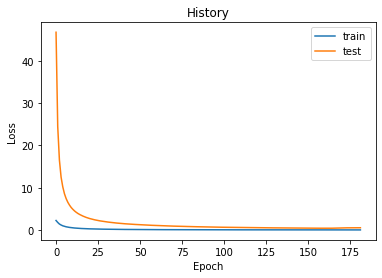

In [83]:
plt.plot(loss_train, label='train')
plt.plot(loss_test, label='test')
plt.title('History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [84]:
temp = test_y - model(np.array(test_x))

In [85]:
resid = []
for t in temp.values[0]:
  resid.append(t.numpy())

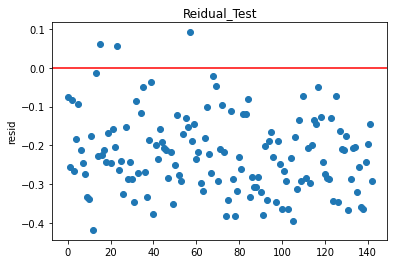

In [86]:
plt.scatter(np.arange(0, 143), resid, label='resid')
plt.axhline(0, color='red')
plt.title('Reidual_Test')
plt.ylabel('resid')
plt.show()

In [87]:
temp_t = train_y - model(np.array(train_x))

In [88]:
resid_t = []
for t in temp_t.values[0]:
  resid_t.append(t.numpy())

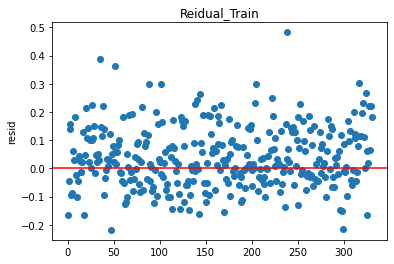

In [89]:
plt.scatter(np.arange(0, len(resid_t)), resid_t, label='resid')
plt.axhline(0, color='red')
plt.title('Reidual_Train')
plt.ylabel('resid')
plt.show()

In [93]:
model.get_weights()[-2]

array([[ 0.00596053],
       [ 0.00984266],
       [-0.0078534 ],
       [-0.00970781],
       [-0.12734756],
       [-0.00437417],
       [-0.25384393],
       [ 0.16178411],
       [ 0.0123756 ],
       [-0.0025482 ],
       [ 0.2792135 ],
       [-0.00208473],
       [ 0.00720521],
       [-0.08458365],
       [ 0.22532806],
       [-0.05251437],
       [ 0.00057672],
       [ 0.01814896],
       [ 0.0081973 ]], dtype=float32)